In [2]:
%run init_notebook.py
import seaborn as sns
from scipy import stats 
import random
import cmapy


Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2024-11-01T16:09:42.889938+01:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : MSC v.1936 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit

numpy      : 1.24.4
arviz      : 0.16.1
IPython    : 8.15.0
xarray     : 2023.8.0
watermark  : 2.5.0
pymc       : 5.8.0
scipy      : 1.11.2
pandas     : 2.1.0
statsmodels: 0.14.0
matplotlib : 3.9.2



In [3]:
HOWELL = utils.load_data("Howell1")
filt = HOWELL['age'] >= 18
df = HOWELL[filt]

<Axes: xlabel='height', ylabel='weight'>

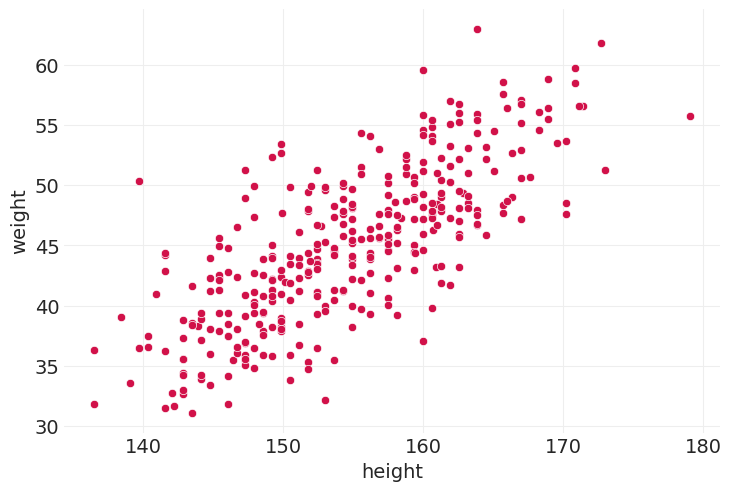

In [4]:
sns.scatterplot(data=df, x='height', y='weight')

### (2) Scientific Generative Model
How does **height** influence **weight**?

$$
\begin{align}
H \rightarrow W \\
W = f(H, U)
\end{align}
$$

i.e. *"Weight is some function of height and unobserved"*

### Linear regression model

We need a function that maps adult weight as a proportion of height plus some unobserved/unaccounted-for causes. Enter **Linear Regression**:

$$W = \beta H + U$$


### Generative model description:
$$
\begin{align}
W_i &= \beta H_i + U_i \\
U_i &\sim \text{Normal}(0, \sigma) \\
H_i &\sim \text{Uniform}(130, 170)
\end{align}
$$

### Describing models
- Variables on the left
- Definition on right
- $\sim$ indicates sampling from a distribution
  - e.g. $H_i \sim \text{Uniform}(130, 170)$ is definition that _height is distributed uniformly between 130 and 170_
- $=$ indicates statistical expectation or deterministic equality
  - e.g. $W_i = \beta H_i + U_i$ is definition of equation for _expected weight_
- subscripts $i$ indicates index of a observation/individual
- generally code will be written in opposite direction, because you need variables defined in order to be referenced/composed

In [5]:
def generate_weights(std, beta, n):
    H = stats.uniform.rvs(130,40, size = n)
    U = stats.norm.rvs(loc=0, scale = std, size = H.shape[0])
    W = beta*H + U
    
    return W, H, U

In [6]:
W, H, U = generate_weights(std=5, beta=0.5, n=200)

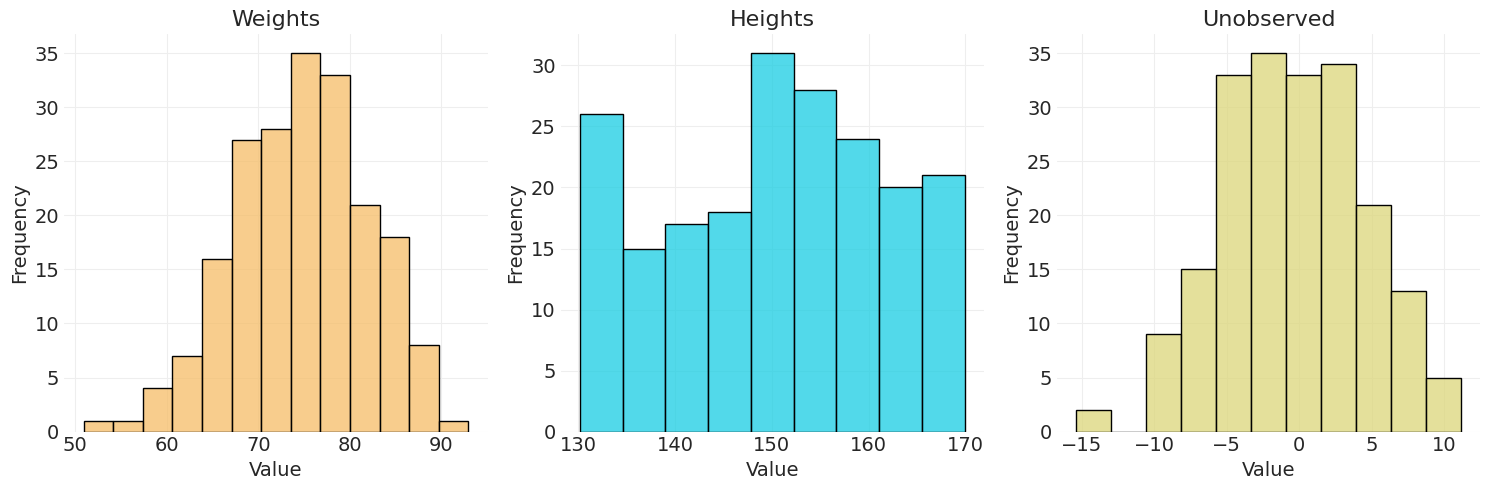

In [7]:
variable_names = ['Weights', 'Heights', 'Unobserved']
variables = [W, H, U]

# Create the figure and axes
num_vars = len(variables)
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars * 5, 5))  # 1 row, num_vars columns

# Loop through the variables and names
for ax, var_name, var_data in zip(axes, variable_names, variables):
    # Get a random color from the 'viridis' colormap
    random_index = random.randint(0, 255)  # Generate a random index between 0 and 255
    rgbs = cmapy.color('rainbow', random_index, rgb_order=True)  # Get the color from the colormap
    color = []
    for i in rgbs:
        rgb = i/255
        color.append(rgb)
    # Plot the histogram on the specific axes
    sns.histplot(var_data, ax=ax, color=color)  
    ax.set_title(var_name)  # Set title using the variable name
    ax.set_xlabel('Value')  # Set x-axis label
    ax.set_ylabel('Frequency')  # Set y-axis label

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot


Text(0.5, 0, 'Heights')

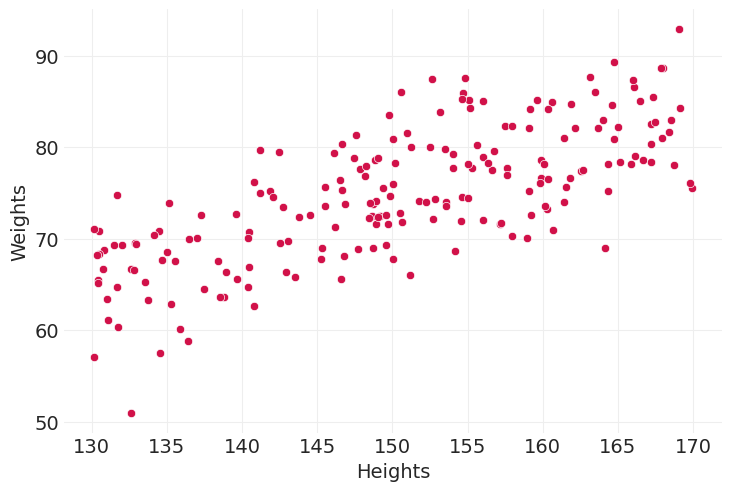

In [8]:
sns.scatterplot(x=H, y=W)
plt.ylabel("Weights")
plt.xlabel("Heights")

#### 3 Statistical Model
We are now ready to develop an estimator, after defining generative model in 2)

In [16]:
# Model function required for simulation
def linear_model(x: np.ndarray, intercept: float, slope: float) -> np.ndarray:
    return intercept + slope * x

# Posterior function required for simulation
def linear_regression_posterior(
    x_obs: np.ndarray,
    y_obs: np.ndarray,
    intercept_grid: np.ndarray,
    slope_grid: np.ndarray,
    likelihood_prior_std: float = 1.0
) -> np.ndarray:
    
    # Convert params to 1-d arrays
    if np.ndim(intercept_grid) > 1:
        intercept_grid = intercept_grid.ravel()
    
    if np.ndim(slope_grid):
        slope_grid = slope_grid.ravel()
    
    log_prior_intercept = stats.norm(0, 1).logpdf(intercept_grid)
    log_prior_slope = stats.norm(0, 1).logpdf(slope_grid)
    
    log_likelihood = np.array(
        [
            stats.norm(
                intercept + slope * x_obs,
                likelihood_prior_std
            ).logpdf(y_obs) for intercept, slope in zip(intercept_grid, slope_grid)
        ]
    ).sum(axis=1)
    
    # Posterior is equal to the product of likelihood and priors (here a sum in log scale)
    log_posterior = log_likelihood + log_prior_intercept + log_prior_slope

    # Convert back to natural scale
    return np.exp(log_posterior - log_posterior.max())

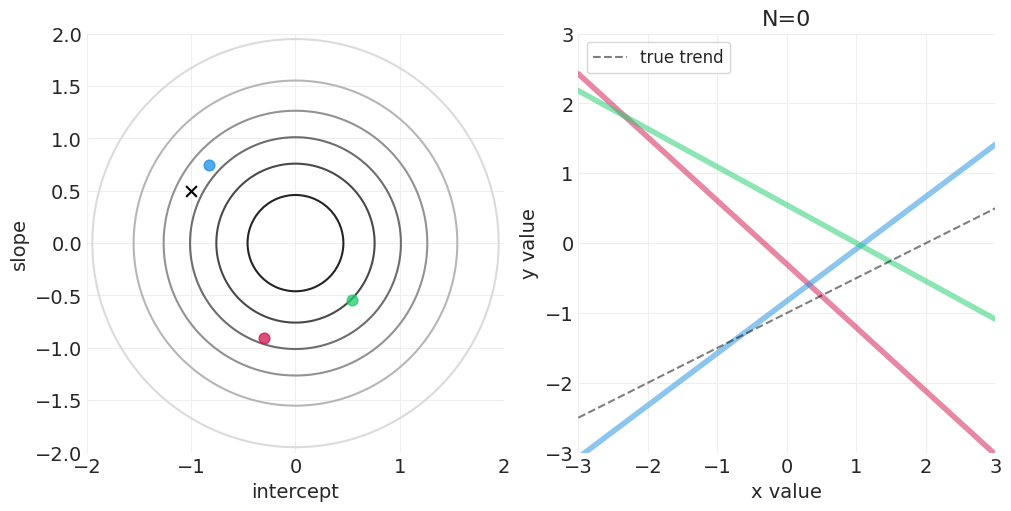

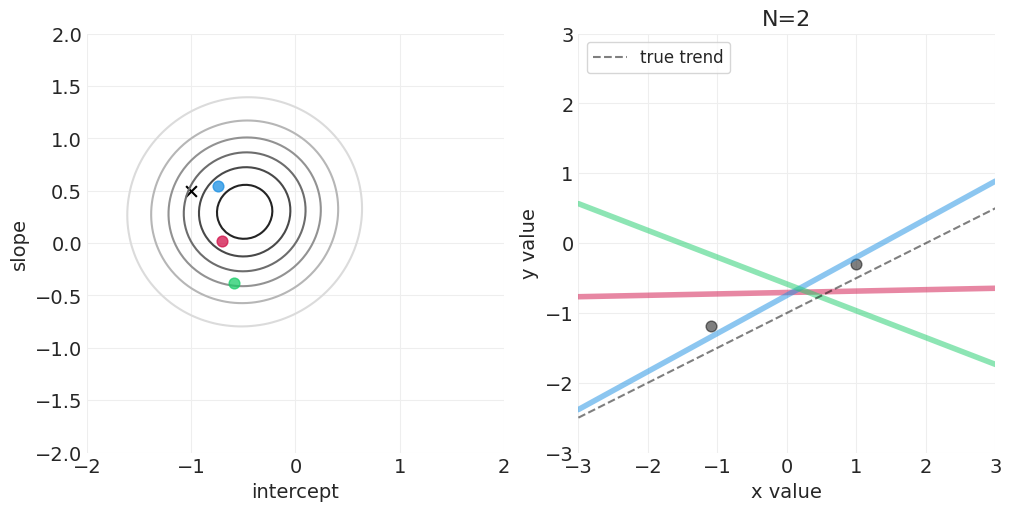

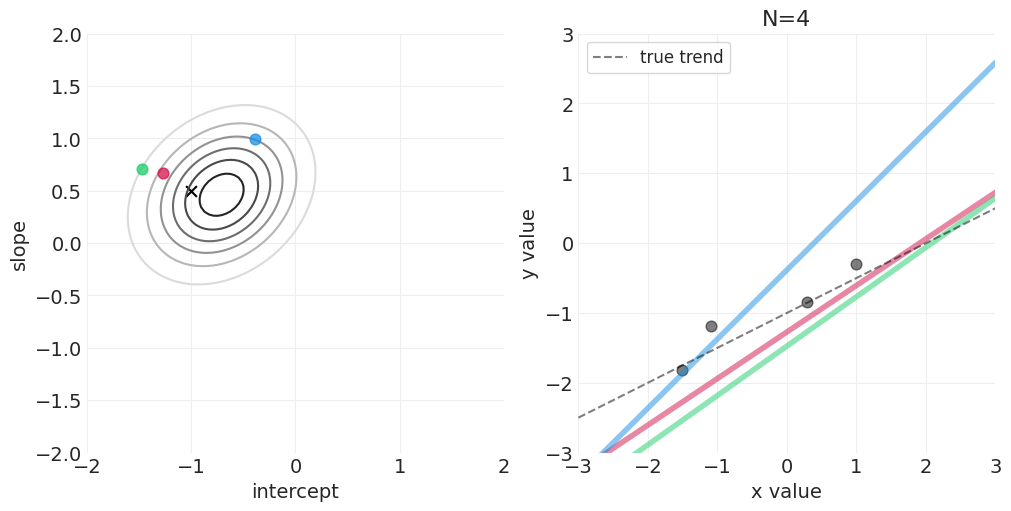

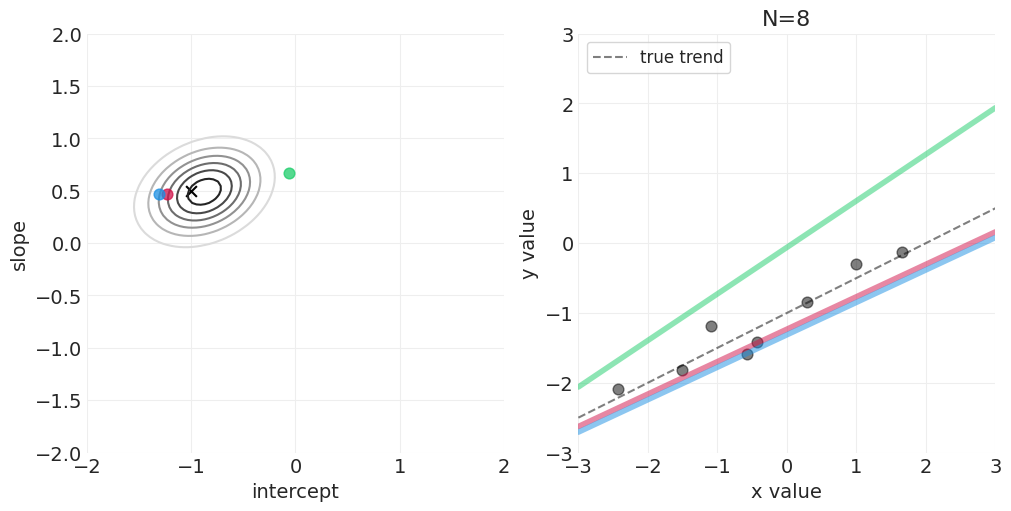

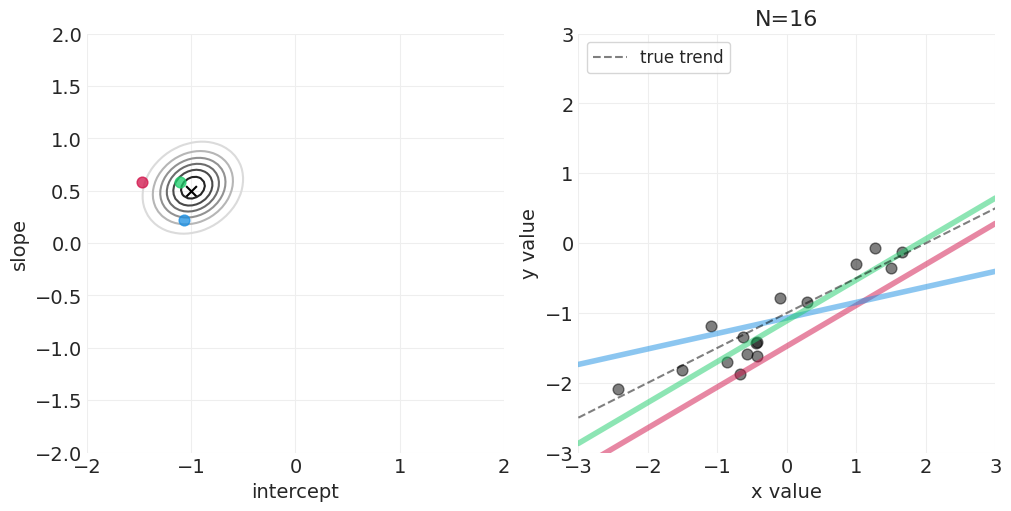

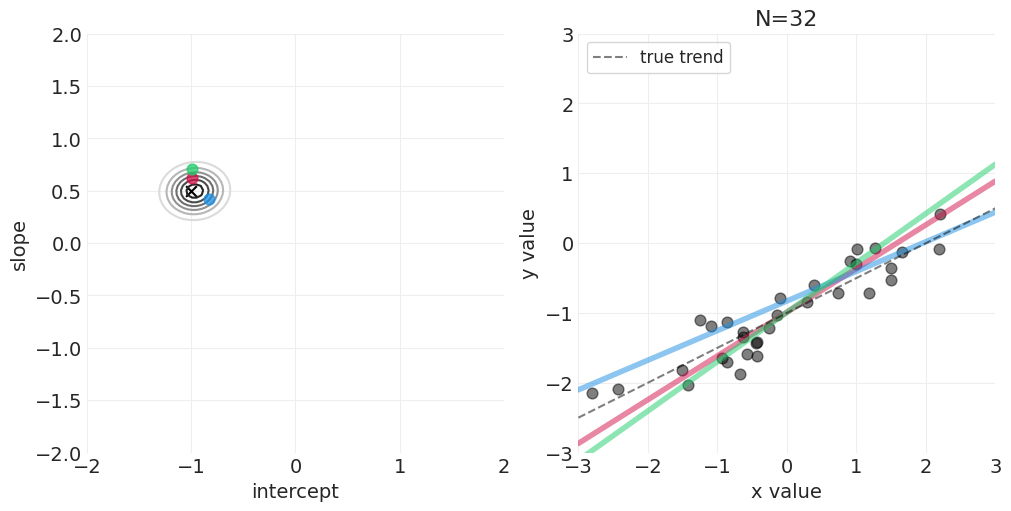

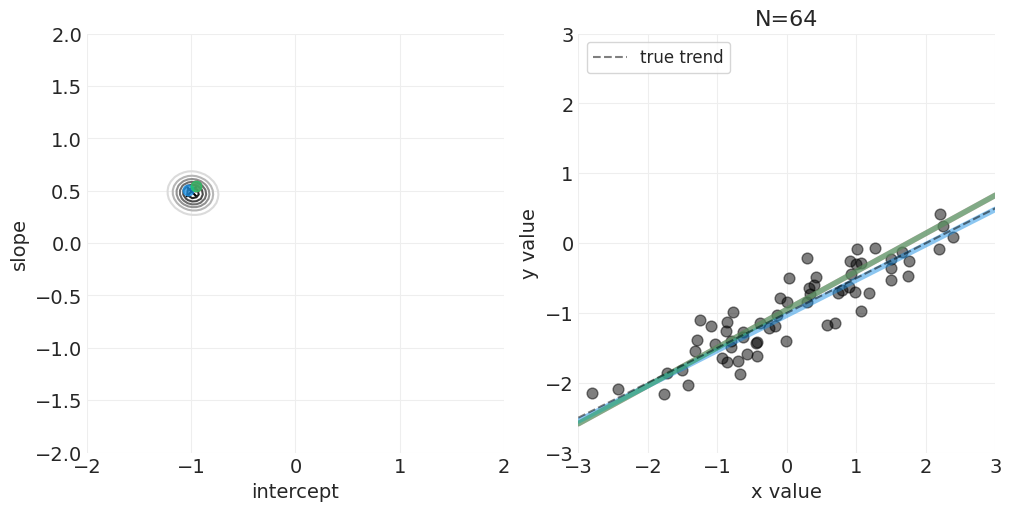

In [17]:
# Generate standardized regression data for demo
np.random.seed(123)
RESOLUTION = 100
N_DATA_POINTS = 64

# # Ground truth parameters
SLOPE = 0.5
INTERCEPT = -1

x = stats.norm().rvs(size=N_DATA_POINTS)
y = INTERCEPT + SLOPE * x + stats.norm.rvs(size=N_DATA_POINTS) * 0.25

slope_grid = np.linspace(-2, 2, RESOLUTION)
intercept_grid = np.linspace(-2, 2, RESOLUTION)

# # Vary the sample size to show how the posterior adapts to more and more data
for n_samples in [0, 2, 4, 8, 16, 32, 64]:
#     # Run the simulation
    utils.simulate_2_parameter_bayesian_learning_grid_approximation(
        x_obs=x[:n_samples],
        y_obs=y[:n_samples],
        param_a_grid=intercept_grid,
        param_b_grid=slope_grid,
        true_param_a=INTERCEPT,
        true_param_b=SLOPE,
        model_func=linear_model,
        posterior_func=linear_regression_posterior,
        param_labels=['intercept', 'slope'],
        data_range_x=(-3, 3), data_range_y=(-3, 3)
    )



#### Prior predictive distributions
* priors should be set reasonably, so that the model doesnt generate non-sense before seing data

So in our case:
* When H=0, W=0
* Weight increases on avg with height
* Weight in kg is less than height in cm, so Beta should be positive, but not larger than 1
* sigma (std) must be positive
* we can understand the implications of priors by running simulations (!)

$$
\begin{align}
\alpha &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Uniform}(0, 1) \\
\sigma &\sim \text{Uniform}(0, 10) \\
\end{align}
$$


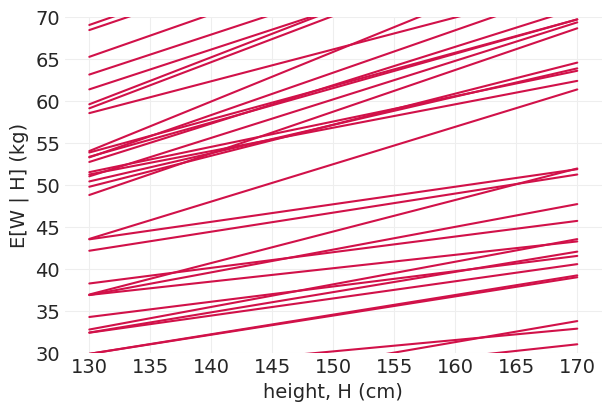

In [ ]:
# NOW WE ARE RUNNING A PRIOR PREDICTIVE SIMULATION

n_simulations = 100

alphas = np.random.normal(0, 10, n_simulations)
betas = np.random.uniform(0, 1, n_simulations)  # beta should all be positive
heights = np.linspace(130, 170, n_simulations)

fig, ax = plt.subplots(figsize=(6, 4))
for a, b in zip(alphas, betas):
    weights = a + b * heights
    plt.plot(heights, weights, color='C0')

plt.xlabel("height, H (cm)")
plt.ylabel("E[W | H] (kg)")
plt.ylim((30, 70));


And we can see, thanks to the prior predictive simulation that:
* some of our lines are very unrealistic, such as predicting for a 170cm a weight of 30 kg on average
* the slope (beta) seems reasonable


#### 4. Validate Model
* we have a generative model that produces synthetic people
* we have an estimator (in course quadriatic approximation but we will use MCMC)
* now we can feed synthetic people into the model

In [57]:
linear_regression_inferences = []
linear_regression_models = []

sample_sizes = [1, 2, 10, 20, 50, len(H)]

for sample_size in sample_sizes:
    print(f"Sample size: {sample_size}")
    with pm.Model() as model:
        
        # Mutable data for posterior predictive visualization
        H_ = pm.MutableData("H", H[:sample_size], dims="obs_id")
        
        # Priors
        alpha = pm.Normal("alpha", 0, 10)  # Intercept
        beta = pm.Uniform("beta", 0, 1)  # slope
        sigma = pm.Uniform("sigma", 0, 10)  # Noise variance
        
        # Likelihood
        mu = alpha + beta * H_
        pm.Normal("W_obs", mu, sigma, observed=W[:sample_size], dims="obs_id")
        
        # Sample posterior
        inference = pm.sample(target_accept=.99)
        linear_regression_inferences.append(inference)
        linear_regression_models.append(model)
        

Sample size: 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 200


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### 5. Analyze Real data

In [58]:
with pm.Model() as howell_model:

    # Mutable data for posterior predictive / visualization
    H_ = pm.MutableData("H", df.height.values, dims="obs_ids")

    # priors
    alpha = pm.Normal("alpha", 0, 10)  # Intercept
    beta = pm.Uniform("beta", 0, 1)  # Slope
    sigma = pm.Uniform("sigma", 0, 10)  # Noise variance

    # likelihood
    mu = alpha + beta * H_
    pm.Normal("W_obs", mu, sigma, observed=df.weight.values, dims="obs_ids")

    # Sample posterior
    howell_inference = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 58 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [59]:
az.summary(howell_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-43.064,4.066,-52.088,-36.456,0.183,0.131,507.0,418.0,1.0
beta,0.570,0.026,0.527,0.627,0.001,0.001,505.0,398.0,1.0
sigma,4.280,0.156,4.022,4.589,0.006,0.004,667.0,773.0,1.0


In [67]:
howell_inference['posterior'].sel(chain=0)['alpha']

<xarray.DataArray 'alpha' (draw: 1000)>
array([-51.31441491, -53.47614738, -44.22479028, -39.98437645,
       -45.43172602, -45.88712574, -43.84649826, -42.12761517,
       -41.62246132, -40.07131836, -40.03776906, -39.94874516,
       -38.93090518, -43.96054307, -43.98528272, -38.54955071,
       -40.63292923, -44.11299529, -44.97193637, -45.12294305,
       -45.1608588 , -45.32156369, -45.35419829, -43.82599594,
       -42.0792875 , -44.53458256, -44.03423523, -46.9095543 ,
       -39.95308129, -40.22196247, -40.27370121, -38.55047898,
       -38.16415957, -38.50471618, -41.91306613, -44.00746624,
       -43.88417192, -41.44030094, -38.6126759 , -38.90219818,
       -46.50198872, -38.83722542, -38.32087643, -38.74727067,
       -38.1845335 , -40.15999833, -43.03769359, -46.36831156,
       -40.87570608, -38.17454904, -46.47983728, -41.83925629,
       -43.78936315, -43.52941572, -40.8441335 , -41.07910989,
       -39.24219959, -39.37170857, -37.96751147, -41.08687837,
       -41.3252818 , -43.07725937, -43.69343881, -43.94272816,
       -43.77624227, -44.05224906, -43.05481666, -40.0319544 ,
       -37.38208341, -37.03978879, -38.93427456, -38.89490741,
       -47.72621644, -46.47369641, -46.60965174, -46.89405338,
       -48.8753876 , -49.29858334, -49.00407178, -46.89327623,
...
       -44.67515822, -41.77060061, -41.29440944, -41.78936974,
       -41.84093547, -41.74511728, -36.19222616, -50.47556315,
       -39.49191035, -39.37851629, -40.77679218, -41.70344499,
       -41.78367898, -41.7076417 , -44.44100628, -49.17644102,
       -39.05509469, -39.10239457, -40.60772873, -49.76097599,
       -43.5023344 , -43.86404233, -43.6553682 , -41.67172575,
       -42.01475938, -42.32681233, -42.01351987, -40.53198741,
       -39.79340899, -39.99469652, -40.80542726, -38.6694936 ,
       -38.89991312, -39.00430061, -47.49152814, -36.45884841,
       -38.0485347 , -39.31227077, -41.56288672, -40.28126283,
       -40.42806104, -40.04855226, -43.9578268 , -41.22961829,
       -41.04943444, -47.75254581, -48.04433803, -46.17798429,
       -47.93050993, -39.40826208, -44.87996746, -42.37317161,
       -37.14220449, -37.24589051, -42.87819766, -42.36392165,
       -42.17078439, -42.34494293, -40.56612635, -45.48679344,
       -44.89409258, -43.16608179, -42.31815917, -40.72720235,
       -38.42509653, -39.41750407, -36.74016051, -46.04599323,
       -41.73212649, -39.70919908, -38.6979767 , -36.65627311,
       -44.53678434, -44.33972285, -44.15911863, -38.18520681,
       -38.46063375, -37.50673193, -37.61123996, -52.0704366 ])
Coordinates:
    chain    int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

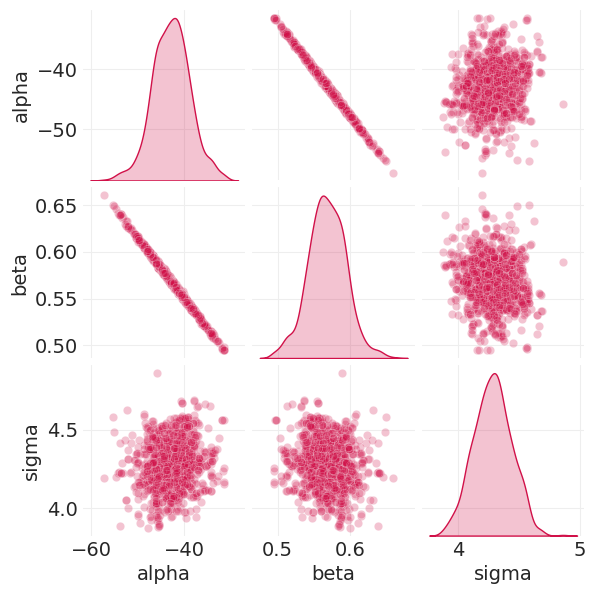

In [60]:
sns.pairplot(
    pd.DataFrame(
        
        {
            "alpha": howell_inference.posterior.sel(chain=0)['alpha'],
            "beta": howell_inference.posterior.sel(chain=0)['beta'],
            "sigma": howell_inference.posterior.sel(chain=0)['sigma'],
        }
    ),
    diag_kind="kde",
    plot_kws={"alpha": .25},
    height=2
);